# [ELEN0016] Computer Vision: 2021 Project

### Preliminary Notes

In order to realize the best performances, our code use cuda to paralelize deep learning and computer vision operation. </br>

This imply that if the parameter 'cuda' is given for the variable DEVICE, this code will be using the CUDA implementation of some operations of the library OpenCV. So, OpenCV cuda must be previously compilled and installed in the environment that you are using. </br>

If a gpu compatible with cuda or the cuda-OpenCV library is not available, this code can be run by using the value 'cpu' for the following variable DEVICE.

Our code need the following requirements:

    albumentations==1.1.0
    matplotlib==3.5.0
    numba==0.54.1
    numpy==1.20.0
    pandas==1.3.4
    Pillow==8.4.0
    scikit-learn==1.0.1
    Shapely==1.8.0
    tensorboard==2.7.0
    torch==1.10.0+cu102
    torchvision==0.11.1+cu102
    tqdm==4.62.3
    + OpenCV 4.5.4 compilled with cuda and contribs or OpenCV python + contribs if used on cpu.

# Data Downloading from Cytomine

In the following code, we are downloading the original dataset from the cytomine plateforme and we store it in the targeted data path. 

In [1]:
from CytomineDownloader import download_images, download_annotations, prepare_data_folders
import torch
import numpy as np
import cv2
import os
import time
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from ReadingBuffer import ReadingBuffer
from MOG_Filter import MOG_filter
from DropletDetector import DropletDetector
from UNetBuffer import UNetBuffer
from UNetThread import UNetThread
from utils import convert_annot
from utils import convert_pred
from utils import get_result_idx
from utils import gound_truth_compare
from utils import intersectionOverUnion
from UNet_DatasetBuilder import create_UNet_dataset


public_key = '5b827fdf-3d3a-4cfc-a831-8016b0ec122d'
private_key = 'b52b59a9-95e4-4d95-b968-951b82860b50'

DATA_PATH = 'Original_Dataset'
UNET_DATA_PATH = 'UNet_Dataset'
UNET_PATH = 'Model'
UNET_NAME = 'UNet_A'
OUTPUT_PATH = 'Output_Results'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BUFFER_SIZE = 500
# Prepare data folders
prepare_data_folders(DATA_PATH)

# Folder preparation if first execution:
if not os.path.exists(DATA_PATH):
    os.mkdir(DAT_PATH)
if not os.path.exists(UNET_PATH):
    os.mkdir(UNET_PATH)
if not os.path.exists(OUTPUT_PATH):
    os.mkdir(OUTPUT_PATH)
if not os.path.exists('Figs'):
    os.mkdir('Figs')


In [4]:
# Download annotations
download_annotations(public_key, private_key, DATA_PATH)

### GROUP: CV2021_GROUP16 ###
### GROUP: CV2021_GROUP20 ###
### GROUP: CV2021_GROUP17 ###
### GROUP: CV2021_GROUP19 ###
### GROUP: CV2021_GROUP14 ###
### GROUP: CV2021_GROUP18 ###
### GROUP: CV2021_GROUP15 ###
### GROUP: CV2021_GROUP09 ###
### GROUP: CV2021_GROUP07 ###
### GROUP: CV2021_GROUP04 ###
### GROUP: CV2021_GROUP05 ###
### GROUP: CV2021_GROUP11 ###
### GROUP: CV2021_GROUP02 ###
### GROUP: CV2021_GROUP06 ###
### GROUP: CV2021_GROUP12 ###
### GROUP: CV2021_GROUP01 ###
### GROUP: CV2021_GROUP03 ###
### GROUP: CV2021_GROUP08 ###
### GROUP: CV2021_GROUP13 ###
### GROUP: CV2021_GROUP10 ###


In [2]:
# Dowload videos
download_images(public_key, private_key, DATA_PATH)

[2021-12-07 13:54:41,892][INFO] [GET] [currentuser] CURRENT USER - 9873550 : s103816 | 200 OK
[2021-12-07 13:54:41,995][INFO] [GET] [project collection] 20 objects | 200 OK
[2021-12-07 13:54:42,095][INFO] [GET] [imageinstance collection] 1 objects | 200 OK
[2021-12-07 13:54:55,756][INFO] File downloaded successfully from https://learn.cytomine.be/api/imageinstance/11222407/download with parameters {}
[2021-12-07 13:54:56,321][INFO] [GET] [imageinstance collection] 1 objects | 200 OK
[2021-12-07 13:55:09,441][INFO] File downloaded successfully from https://learn.cytomine.be/api/imageinstance/11227490/download with parameters {}
[2021-12-07 13:55:09,935][INFO] [GET] [imageinstance collection] 1 objects | 200 OK
[2021-12-07 13:55:22,787][INFO] File downloaded successfully from https://learn.cytomine.be/api/imageinstance/11223675/download with parameters {}
[2021-12-07 13:55:22,821][INFO] [GET] [imageinstance collection] 1 objects | 200 OK
[2021-12-07 13:55:35,775][INFO] File downloaded su

# Statistical Analysis of the data

In this section, we are performing some simple analysis of the annotations in order to have some important knowledges to determines the different thresholds used in our predicting algorithm.

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:20<00:00,  1.00s/it]


# ================================================================= #
#                Statistical analysis of the dataset                #
# ================================================================= #
 
Total number of frames: 24918
Total number of droplets tracker: 2936


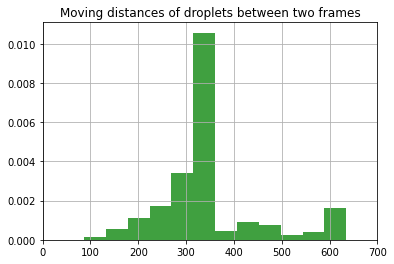

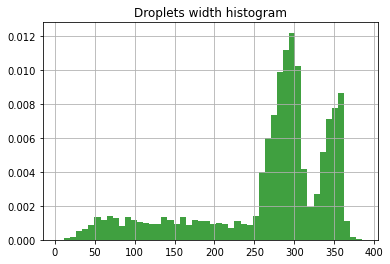

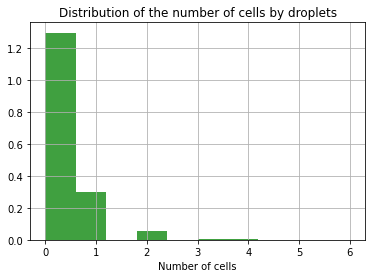

IndexError: list index out of range

In [2]:
from DataStatistics import data_statistics

data_statistics(DATA_PATH)

# Dataset Creation for the UNet Training

The UNet is responsible of the cell counting in the droplets.
To create this dataset, we are using provided annotations to 
create a database of droplets images with cells coordinates in
it.

In [2]:
# Get the list of all video files:
file_lst = os.listdir('{}/images'.format(DATA_PATH))
start_idx = 0
for i in tqdm(range(0, len(file_lst))):
    # Get paths
    gp_str = file_lst[i][-2:]
    gp = int(gp_str)
    vid_path = '{}/images/{}/group{}.mp4'.format(DATA_PATH, file_lst[i], gp)
    annot_path = '{}/annotations/{}/{}.csv'.format(DATA_PATH, file_lst[i], file_lst[i])

    # Extract droplets images
    start_idx = create_UNet_dataset(vid_path, annot_path, start_idx, UNET_DATA_PATH)

100%|██████████| 20/20 [00:43<00:00,  2.15s/it]


# UNet Training

In [2]:
from UNet_Trainer import train

train(data_path=UNET_DATA_PATH,
      model_path=UNET_PATH,
      name=UNET_NAME,
      batch_size=15,
      learning_rate=1e-5,
      weight_decay=0,
      num_workers=4,
      target_epoch=10
     )

Training at epoch 1 / 10



100%|██████████| 933/933 [05:17<00:00,  2.94it/s, loss=0.0143] 


Training at epoch 2 / 10



100%|██████████| 933/933 [05:09<00:00,  3.01it/s, loss=0.00372]


Training at epoch 3 / 10



100%|██████████| 933/933 [05:08<00:00,  3.02it/s, loss=0.0103] 


Training at epoch 4 / 10



100%|██████████| 933/933 [05:07<00:00,  3.04it/s, loss=0.0031] 


Training at epoch 5 / 10



100%|██████████| 933/933 [05:06<00:00,  3.04it/s, loss=0.00529]


Training at epoch 6 / 10



100%|██████████| 933/933 [05:07<00:00,  3.03it/s, loss=0.00378]


Training at epoch 7 / 10



100%|██████████| 933/933 [05:07<00:00,  3.04it/s, loss=0.00861] 


Training at epoch 8 / 10



100%|██████████| 933/933 [05:06<00:00,  3.04it/s, loss=0.00645]


Training at epoch 9 / 10



100%|██████████| 933/933 [05:07<00:00,  3.04it/s, loss=0.00878] 


Training at epoch 10 / 10



100%|██████████| 933/933 [05:07<00:00,  3.04it/s, loss=0.00736]


### Plot training curves

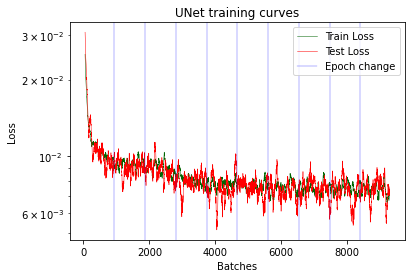

In [3]:
from UNet_Trainer import plot_UNet_logs

plot_UNet_logs(model_path=UNET_PATH,
               model_name=UNET_NAME)

# Video Analysis

In this video, we will makes the final predictions for all the videos of our provided dataset. In order to analyze the execution of our muti-thread algorithm and to detect potentials bottle-necks in it, the load of our buffers is evaluate for each time steps of the execution.

### Get video of interest path's

In [3]:
# Get the list of all input video
video_list = os.listdir('{}/annotations'.format(DATA_PATH))
# Get all path to target videos
target_vid = []
print('* Target videos: ')
for itm in video_list:
    # Get groupe number
    gp_str = itm[-2:]
    gp = int(gp_str)
    tmp = '{}/images/{}/group{}.mp4'.format(DATA_PATH, itm, gp)
    target_vid.append(tmp)
    print('*   - {}'.format(tmp))

* Target videos: 
*   - Original_Dataset/images/CV2021_GROUP01/group1.mp4
*   - Original_Dataset/images/CV2021_GROUP02/group2.mp4
*   - Original_Dataset/images/CV2021_GROUP03/group3.mp4
*   - Original_Dataset/images/CV2021_GROUP04/group4.mp4
*   - Original_Dataset/images/CV2021_GROUP05/group5.mp4
*   - Original_Dataset/images/CV2021_GROUP06/group6.mp4
*   - Original_Dataset/images/CV2021_GROUP07/group7.mp4
*   - Original_Dataset/images/CV2021_GROUP08/group8.mp4
*   - Original_Dataset/images/CV2021_GROUP09/group9.mp4
*   - Original_Dataset/images/CV2021_GROUP10/group10.mp4
*   - Original_Dataset/images/CV2021_GROUP11/group11.mp4
*   - Original_Dataset/images/CV2021_GROUP12/group12.mp4
*   - Original_Dataset/images/CV2021_GROUP13/group13.mp4
*   - Original_Dataset/images/CV2021_GROUP14/group14.mp4
*   - Original_Dataset/images/CV2021_GROUP15/group15.mp4
*   - Original_Dataset/images/CV2021_GROUP16/group16.mp4
*   - Original_Dataset/images/CV2021_GROUP17/group17.mp4
*   - Original_Dataset

### Load all components

In [4]:
# Build the reading buffer
buff_read = ReadingBuffer(path_list=target_vid,
                          buff_size=BUFFER_SIZE,
                          device=DEVICE)
# The MOG filter thread
buff_mog = MOG_filter(input_buffer=buff_read,
                      buff_size=BUFFER_SIZE,
                      device=DEVICE)
# The Droplet detector/counter
buff_droplet = DropletDetector(input_buffer=buff_mog,
                               buff_size=BUFFER_SIZE,
                               device=DEVICE,
                               debug=False)

# A buffer for the UNet: do the tensorisation step
buff_UNet = UNetBuffer(input_buffer=buff_droplet,
                       buff_size=BUFFER_SIZE,
                       device=DEVICE,
                       display=False)

# The UNet thread to count cells
UNet_thread = UNetThread(input_buffer=buff_UNet,
                         model_path=UNET_PATH,
                         model_name=UNET_NAME,
                         device=DEVICE,
                         batch_size=10,
                         debug=False)

Unet sucessfully loaded


### Prediction Step
In this code, the main loop track the filling of each buffers during the execution and stope when the last buffer end his work.

* --------------------------------------------------------- *
*                    Results:                  
*   - Counted droplets: 3353
*   - Counted cells: 737
*   - Computing Time: 49.82753038406372
*   - Readed frames: 24952
*   - Frames per seconds: 500.76734302650425
* --------------------------------------------------------- *


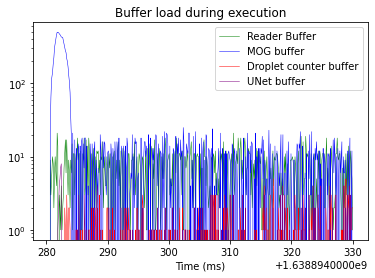

In [5]:
# Filling track
fill_reader = []
fill_mog = []
fill_drp_counter = []
fill_UNet_buff = []
time_array = []

# Starting threads
start_time = time.time()
buff_read.start()
buff_mog.start()
buff_droplet.start()
buff_UNet.start()
UNet_thread.start()

while not UNet_thread.end:
    
    fill_reader.append(buff_read.buffer.qsize())
    fill_mog.append(buff_mog.buffer.qsize())
    fill_drp_counter.append(buff_droplet.buffer.qsize())
    fill_UNet_buff.append(buff_UNet.buffer.qsize())
    time_array.append(time.time())
    time.sleep(0.1)
    
end_time = time.time()

print('* --------------------------------------------------------- *')
print('*                    Results:                  ')
print('*   - Counted droplets: {}'.format(buff_droplet.drop_counter))
print('*   - Counted cells: {}'.format(UNet_thread.total_cell))
print('*   - Computing Time: {}'.format(end_time - start_time))
total_frame_idx = buff_read.frame_idx
print('*   - Readed frames: {}'.format(total_frame_idx))
print('*   - Frames per seconds: {}'.format(total_frame_idx / (end_time - start_time)))
print('* --------------------------------------------------------- *')

# Plot buffers load tracking
x_axis = np.arange(len(fill_reader))
plt.plot(time_array, fill_reader, label='Reader Buffer', color='Green', linewidth=0.5)
plt.plot(time_array, fill_mog, label='MOG buffer', color='Blue', linewidth=0.5)
plt.plot(time_array, fill_drp_counter, label='Droplet counter buffer', color='Red', linewidth=0.5)
plt.plot(time_array, fill_UNet_buff, label='UNet buffer', color='Purple', linewidth=0.5)
plt.legend()
plt.yscale('log')
plt.title('Buffer load during execution')
plt.xlabel('Time (ms)')
plt.show()
plt.close()


# Model Evaluation
In this part, we will compare predictions of our model to the ground truth.

In [2]:
# Do this for all files in the data
input_files = os.listdir('{}/annotations'.format(DATA_PATH))

### Prediction loop:
In the following part, we are making predictions for all wanted files and we sotre it in the folder /Output_Results

In [3]:
for input_name in input_files:
    
    # Get the group number and the video path
    gp = int(input_name[-2:])
    video_path = '{}/images/{}/group{}.mp4'.format(DATA_PATH, input_name, gp)
    
    # ================================================= #
    #      Initialization of all components             #
    # ================================================= #
    
    # Build the reading buffer
    buff_read = ReadingBuffer(path_list=[video_path],
                              buff_size=BUFFER_SIZE,
                              device=DEVICE)
    # The MOG filter thread
    buff_mog = MOG_filter(input_buffer=buff_read,
                          buff_size=BUFFER_SIZE,
                          device=DEVICE)
    # The Droplet detector/counter
    buff_droplet = DropletDetector(input_buffer=buff_mog,
                                   buff_size=BUFFER_SIZE,
                                   device=DEVICE,
                                   debug=False)

    # A buffer for the UNet: do the tensorisation step
    buff_UNet = UNetBuffer(input_buffer=buff_droplet,
                           buff_size=BUFFER_SIZE,
                           device=DEVICE,
                           display=False)

    # The UNet thread to count cells
    UNet_thread = UNetThread(input_buffer=buff_UNet,
                             model_path=UNET_PATH,
                             model_name=UNET_NAME,
                             device=DEVICE,
                             batch_size=10,
                             debug=False)
    start_time = time.time()
    buff_read.start()
    buff_mog.start()
    buff_droplet.start()
    buff_UNet.start()
    UNet_thread.start()
    
    # ================================================= #
    #                  Working Loop                     #
    # ================================================= #
    
    while not UNet_thread.end:
        # Wait the end of the predictions
        time.sleep(0.1)
        
    # Get the execution time
    end_time = time.time()
    
    # ================================================= #
    #                  Export results                   #
    # ================================================= #
    
    print('* -------------------------------------------- *')
    print('* End of predictions for {}'.format(input_name))
    print('* Total readed frames: {}'.format(buff_read.frame_idx))
    print('* Detected droplets: {}'.format(buff_droplet.drop_counter))
    print('* Detected cells: {}'.format(UNet_thread.total_cell))
    print('* Computing time: {}'.format(end_time - start_time))
    total_frame_idx = buff_read.frame_idx
    print('* Frames per second: {}'.format(total_frame_idx / (end_time - start_time)))
    
    # We deduce the number of droplets without cell
    nb_zero_cell = buff_droplet.drop_counter - sum(UNet_thread.histogram)
    UNet_thread.histogram[0] = nb_zero_cell
    # We build the histogram
    histo = []
    i = 0
    print('* Histogram of the number of cell per droplet:')
    for itm in UNet_thread.histogram.tolist():
        histo.append(str(int(itm)))
        print('*   - Droplets with {} cells: {}'.format(i, itm))
        i += 1
    
    # Write it in the output file: 
    f = open('{}/{}_histo.csv'.format(OUTPUT_PATH, input_name), 'w')
    f.write(','.join(histo))
    f.close()
    
    # Export detected object coordinates
    results_drp = buff_droplet.final_results
    results_cell = UNet_thread.final_results
    to_print = []
    # Investigate all frame index
    for i in range(0, total_frame_idx):
        x_start = 0
        finded = False
        # Check if droplet at this index
        for j in range(0, len(results_drp)):
            if results_drp[j][0] == i:
                to_print.append('frame_{},{},0,{},240,droplet'.format(i,
                                                                        results_drp[j][1],
                                                                        results_drp[j][2]))
                x_start = results_drp[j][1]
                finded = True
                
        # If we have a droplet at this frame, we check if cells are present
        if finded: 
            for j in range(0, len(results_cell)):
                if results_cell[j][0] == i:
                    to_print.append('frame_{},{},{},{},{},cell'.format(i,
                                                                         results_cell[j][3]-20+x_start,
                                                                         results_cell[j][4]-20,
                                                                         results_cell[j][3]+20+x_start,
                                                                         results_cell[j][4]+20))
    # Save in a file
    f = open('{}/{}_track.csv'.format(OUTPUT_PATH, input_name), 'w')
    f.write('\n'.join(to_print))
    f.close()

Unet sucessfully loaded
* -------------------------------------------- *
* End of predictions for CV2021_GROUP01
* Total readed frames: 1252
* Detected droplets: 114
* Detected cells: 36
* Computing time: 6.150038242340088
* Frames per second: 203.57596988268716
* Histogram of the number of cell per droplet:
*   - Droplets with 0 cells: 84.0
*   - Droplets with 1 cells: 25.0
*   - Droplets with 2 cells: 4.0
*   - Droplets with 3 cells: 1.0
*   - Droplets with 4 cells: 0.0
*   - Droplets with 5 cells: 0.0
*   - Droplets with 6 cells: 0.0
*   - Droplets with 7 cells: 0.0
*   - Droplets with 8 cells: 0.0
*   - Droplets with 9 cells: 0.0
Unet sucessfully loaded
* -------------------------------------------- *
* End of predictions for CV2021_GROUP02
* Total readed frames: 1262
* Detected droplets: 141
* Detected cells: 40
* Computing time: 5.423819303512573
* Frames per second: 232.67736799098446
* Histogram of the number of cell per droplet:
*   - Droplets with 0 cells: 105.0
*   - Droplet

* -------------------------------------------- *
* End of predictions for CV2021_GROUP14
* Total readed frames: 1070
* Detected droplets: 81
* Detected cells: 18
* Computing time: 4.519583702087402
* Frames per second: 236.7474684683487
* Histogram of the number of cell per droplet:
*   - Droplets with 0 cells: 68.0
*   - Droplets with 1 cells: 10.0
*   - Droplets with 2 cells: 2.0
*   - Droplets with 3 cells: 0.0
*   - Droplets with 4 cells: 1.0
*   - Droplets with 5 cells: 0.0
*   - Droplets with 6 cells: 0.0
*   - Droplets with 7 cells: 0.0
*   - Droplets with 8 cells: 0.0
*   - Droplets with 9 cells: 0.0
Unet sucessfully loaded
* -------------------------------------------- *
* End of predictions for CV2021_GROUP15
* Total readed frames: 1267
* Detected droplets: 196
* Detected cells: 35
* Computing time: 5.522932052612305
* Frames per second: 229.4071315617071
* Histogram of the number of cell per droplet:
*   - Droplets with 0 cells: 164.0
*   - Droplets with 1 cells: 29.0
*   - 

### Evaluation loop
In this part, we will compare outputs of the precedent algorithm to the annotations provided on the cytomine plateforme

In [4]:
drp_true_positive = 0
drp_false_positive = 0
drp_false_negative = 0
drp_IOU = []
cell_true_positive = 0
cell_false_positive = 0
cell_false_negative = 0
cell_dist = []
cell_iou = []

for input_name in input_files:
    
    # Load predictions and annotations 
    preds = pd.read_csv('{}/{}_track.csv'.format(OUTPUT_PATH, input_name), header=None, sep=',')
    annot = pd.read_csv('{}/annotations/{}/{}.csv'.format(DATA_PATH, input_name, input_name), sep=';')
    # Sort the input by frame index order
    annot = annot.sort_values(by=['Slice'], ascending=True, ignore_index=True)
    
    # ================================================= #
    #               Annotations conversion              #
    #  We transform the annotation file to the same     #
    #  format that the prediction file:                 #
    #    - Only consider full droplets (>250pxl width)  #
    #    - Only keep the second view of the droplet     #
    #    - Only keep cells of this droplets             #
    # ================================================= #
    max_slice = annot['Slice'].max()
    once_seen_droplet = []
    twice_seen_droplet = []
    new_annot = []

    for i in range(0, max_slice):
        
        # Get annotations at this frame index if exists and convert it in a working format
        tmp = convert_annot(annot[annot['Slice'] == i])

        if len(tmp) == 0:
            continue
        
        # Check if contain a droplet wider than 250pxl
        for itm in tmp:
            if itm [1] == 'droplet':
                if itm[5] - itm[3] > 250:
                    if not itm[2] in once_seen_droplet:
                        once_seen_droplet.append(itm[2])
                    elif itm[2] not in twice_seen_droplet:
                        twice_seen_droplet.append(itm[2])
                        
                        # Store the droplet and his cells in new_annot
                        new_annot.append(itm)
                        # Look at cells in this droplet
                        for j in range(0, len(tmp)):
                            if tmp[j][1] == 'cell':
                                center_x = int((tmp[j][5] + tmp[j][3]) / 2)
                                center_y = int((tmp[j][6] + tmp[j][4]) / 2)
                                if center_x <= itm[5] and center_x >= itm[3]:
                                    if center_y <= itm[6] and center_y >= itm[4]:
                                        new_annot.append(tmp[j])
    
    f = open('Output_Results/{}_annot_test.csv'.format(input_name), 'w')
    for itm in new_annot:
        opt = []
        for tmp in itm:
            opt.append(str(tmp))
        f.write(','.join(opt))
        f.write('\n')
    f.close()
    # ================================================= #
    #      Compare predictions and targets              #
    # ================================================= #
    # Convert pred dataset
    new_pred = convert_pred(preds)
    max_pred_slice = int(preds.iloc[preds.shape[0]-1][0].replace('frame_', ''))
    
    for i in tqdm(range(0, max(max_pred_slice, max_slice))):
        
        # Get indexes in the results array if exists
        pred_idx = get_result_idx(i, new_pred)
        trg_idx = get_result_idx(i, new_annot)
        
        # Get false positive:
        if pred_idx != -1 and trg_idx == -1:
            drp_false_positive += 1
        # Get false negative
        elif pred_idx == -1 and trg_idx != -1:
            drp_false_negative += 1
        elif pred_idx != -1 and trg_idx != -1:
            drp_true_positive += 1
            # Compute the IOU:
            drp_IOU.append(intersectionOverUnion(new_pred[pred_idx][3:], new_annot[trg_idx][3:]))
            
            # Now for the cells in this droplet
            # Get following cells (associated with this droplet)
            pred_cells = []
            idx = pred_idx
            while idx + 1 < len(new_pred):
                idx += 1
                if new_pred[idx][1] == 'cell':
                    pred_cells.append(new_pred[idx])
                else:
                    break
            trg_cells = []
            idx = trg_idx
            while idx + 1 < len(new_annot):
                idx += 1
                if new_annot[idx][1] == 'cell':
                    trg_cells.append(new_annot[idx])
                else:
                    break
            tp, fp, fn, iou, dist = gound_truth_compare(pred_cells, trg_cells, iou_thresh=0.01)
            cell_true_positive += tp
            cell_false_positive += fp
            cell_false_negative += fn
            for dst in dist:
                cell_dist.append(dst)
            for io in iou:
                cell_iou.append(io)


print('* Droplets results: ')
print('*   - True positives: {}'.format(drp_true_positive))
print('*   - False positives: {}'.format(drp_false_positive))
print('*   - False negatives: {}'.format(drp_false_negative))
print('*   - Mean IOU: {}'.format(np.mean(drp_IOU)))
print('* Cells results: ')
print('*   - True positives: {}'.format(cell_true_positive))
print('*   - False positives: {}'.format(cell_false_positive))
print('*   - False negatives: {}'.format(cell_false_negative))
print('*   - Mean euclidean distance: {}'.format(np.mean(cell_dist)))
print('*   - Mean IOU: {}'.format(np.mean(cell_iou)))
            
        

100%|███████████████████████████████████████████████████████████████████████████| 1261/1261 [00:00<00:00, 18862.00it/s]

* Droplets results: 
*   - True positives: 2850
*   - False positives: 285
*   - False negatives: 66
*   - Mean IOU: 0.9503001585040819
* Cells results: 
*   - True positives: 637
*   - False positives: 51
*   - False negatives: 55
*   - Mean euclidean distance: 4.624784799985664
*   - Mean IOU: 0.5595997872887679
